In [3]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) 

import jax
import jax.numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time
import scipy

# Data Pre-Processing

In [4]:
#load attributes csv file
attribute = pd.read_csv("celeba.csv")

#"attribute" is a dictionary containing several attributes for each image
#attribute.keys()

In [5]:
#let us list all the files in the image directory
path = "img_celeba_small"
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant rows in attributes
attribute = attribute[:20000]

Number of images: 20000


## Creating training and validation datasets

In [6]:
# select first 15000 rows for training dataset
train = attribute[:15000]
train = train['Young']

# select last 5000 rows for test dataset
test = attribute[15000:20000]
test = test['Young']

In [17]:
is_Young = train==1
is_Old = train==-1

# subset training set by young/old
train_y = train[is_Young] 
train_o = train[is_Old]

len(train_o)

3331

Of the 15,000 images in the training data, 3331 are old. We will create a balanced dataset with all the old persons.

In [39]:
# sample 3331 observations from all young data in training set
onp.random.seed(0)
y_pindex = onp.random.choice(len(train_y), len(train_o), replace=False)
o_pindex = onp.asarray(list(range(3331)))

In [40]:
train_n = 2665
val_n = len(train_o) - train_n

# select prelim training & validation data
ptrain_y = train_y.iloc[y_pindex[:train_n]]
pval_y = train_y.iloc[y_pindex[train_n:]]

ptrain_o = train_o.iloc[o_pindex[:train_n]]
pval_o = train_o.iloc[o_pindex[train_n:]]

# collate prelim training data (3k obs, 1.5k each class)
ptrain = ptrain_y.append(ptrain_o)
ptrain = ptrain.sort_index()

# collate prelim test data (1k obs, .5k each class)
pval = pval_y.append(pval_o)
pval = pval.sort_index()

`ptrain` is a 1 x 5330 array with the indicator values $\{-1, 1\}$ for old and young. 

`pval` is a 1 x 1332 array with the indicator values $\{-1, 1\}$ for old and young. 

## Loading images

The images were loaded in grayscale with an initial size of 218 by 178 pixels. The pixel intensity was then rescaled to [0,1]. To remove parts of the image irrelevant to a person's age (outside of the face), the images were cropped to only include the range [50:185, 40:135]. The final images used for analysis are 135 by 95 pixels.

In [45]:
h = 218 # original image height
w = 178 # original image weight
h_n = 185-50 # height after cropping
w_n = 135-40 # width after cropping

# load the images from the prelim training set
ntrain_img = len(ptrain)
ptrain_ind = ptrain.index.values
ptrain_img = onp.zeros((ntrain_img,h_n,w_n))

for k in range(ntrain_img):
    im = imageio.imread(os.path.join(path, all_img[ptrain_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2)
    im = im/255.
    im = im[50:185,40:135]
    ptrain_img[k,:,:] = im
    
# load the images from the prelim validation set
nval_img = len(pval)
pval_ind = pval.index.values
pval_img = onp.zeros((nval_img,h_n,w_n))

for k in range(nval_img):
    im = imageio.imread(os.path.join(path, all_img[pval_ind[k]])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2)
    im = im/255.
    im = im[50:185,40:135]
    pval_img[k,:,:] = im
    
# load the images from the test set
ntest_img = 5000
ptest_img = onp.zeros((ntest_img,h_n,w_n))

for k in range(ntest_img):
    im = imageio.imread(os.path.join(path, all_img[k+15000])).astype(float)
    im = resize(im, (h,w))
    im = onp.mean(im, axis=2)
    im = im/255.
    im = im[50:185,40:135]
    ptest_img[k,:,:] = im

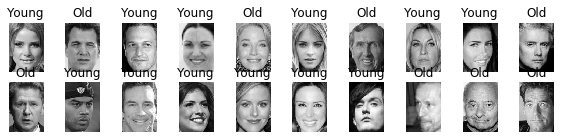

In [46]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = ptrain_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = ptrain.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

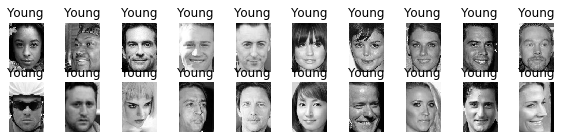

In [47]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = pval_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = pval.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

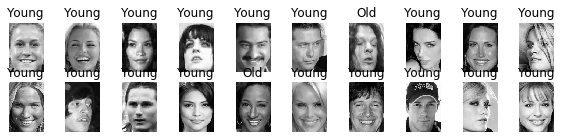

In [48]:
# test if the subsetting was successful
plt.figure(figsize=(10,2))
for k in range(20):
    im = ptest_img[k]
    plt.subplot(2,10,k+1)
    plt.imshow(im/255., cmap='gray')
    plt.axis("off")
    
    is_Young = test.iloc[k]
    if is_Young == 1:
        plt.title("Young")
    else:
        plt.title("Old")

`ptrain` is a 1 x 5330 array with the indicator values $\{-1, 1\}$ for old and young. `ptrain_img` is a 5330 x 135 x 95 array that contains the relevant images for the preliminary training data. 

`pval` is a 1 x 1332 array with the indicator values $\{-1, 1\}$ for old and young. `pval_img`is a 1332 x 135 x 95 array that contains the relevant images for the preliminary validation data. 

`test` is a 1 x 5000 array with with the indicator values $\{-1, 1\}$ for old and young. `ptest_img`is a 5000 x 135 x 95 array that contains the relevant images for the preliminary validation data. 

In [54]:
data_train = ptrain_img.reshape(5330, h_n*w_n)
y_train = ptrain.to_numpy(copy=True)

data_val = pval_img.reshape(1332, h_n*w_n)
y_val = pval.to_numpy(copy=True)

data_test = ptest_img.reshape(5000, h_n*w_n)
y_test = test.to_numpy(copy=True)